<a href="https://colab.research.google.com/github/Lmdela/Trabajo-de-Mineria-de-Datos/blob/Trabajo-Mineria/Redes_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Redes LSTM para la predicción de la temperatura del mar**

**Autores**
1. Antony D'Acunto, adacuntob@unal.edu.co
2. Luisa de la Hortúa, lmdela@unal.edu.co

**Fork**

**Referencias**
1. https://www.kaggle.com/sohier/calcofi
3. https://arxiv.org/pdf/1906.02691.pdf
5. https://new.data.calcofi.org/index.php/database/calcofi-database/bottle-field-descriptions
4. http://colah.github.io/posts/2015-08-Understanding-LSTMs/



**Introducción** 

El conjunto de datos CalCOFI (California Cooperative Oceanic Fischers Investigations) representa la serie de datos oceanográficos y larvarios más larga desde 1949 hasta el presente y más completa (más de 50,000 estaciones de muestreo) del mundo. Incluye datos de abundancia sobre las larvas de más de 250 especies de peces; datos de frecuencia de longitud larval y datos de abundancia de huevos en especies comerciales clave; y datos oceanográficos y de plancton. Los datos físicos, químicos y biológicos recopilados a intervalos regulares de tiempo y espacio rápidamente se volvieron valiosos para documentar los ciclos climáticos en la corriente de California. La investigación de CalCOFI llamó la atención mundial sobre la respuesta biológica al dramático evento del calentamiento del Pacífico en 1957-58 e introdujo el término "El Niño" en la literatura científica.

---



**Planteamiento del problema**

El principal objetivo del problema, es la predicción del cambio de temperatura en el mar, apartir de datos recolectados en estaciones de muestreo. Entre los datos más importantes se encuentran la salinidad, la cantidad de oxigeno por litro en el agua.



**Metodología**

**Redes LSTM:** Son Redes Long Short Term Memory que se usan para el entendimeinto de predicciones que se hacen atraves de secuencias. Hacen parte de las redes neuronales, pero poseen una estructura más elaborada al momento de tratar la información nueva en cada paso. Como se muestra en el siguiente esquema.![texto alternativo](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)


**Base de datos Bottles**

*   Cst_Cnt: Conteo de lanzamientos.
*   Btl_Cnt: Conte de botellas numeradas.
*   Sta_ID: Linea y estación CalCOFI
*   Depth_ID: [Century]-[YY][MM][ShipCode]-[CastType][Julian Day]-[CastTime]-[Line][Sta][Depth][Bottle]-[Rec_Ind]
*   T_degC: Temperatura del agua
*   Salnty: Salinidad del agua
*   O2ml_L: Militros de oxígeno disuelto por litro de agua de mar. 
*   STheta: Densidad potencial del agua. 




En el primer paso se está haciendo la importación de librerias necesarias para el manejo de los datos.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math 
import statistics as stat
import statsmodels.api as sm
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Se hace la lectura de la base de datos que vamos a usar, en este caso es una base llamada "Bottles" que puede ser encontrada en Kaggle en el primer link en las referencias.

In [0]:
dataframe = pd.read_csv(r"bottle.csv", sep=(";"), engine="python")
dataframe

,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,BtlNum,RecInd,T_prec,T_qual,S_prec,S_qual,P_qual,O_qual,SThtaq,O2Satq,ChlorA,Chlqua,Phaeop,Phaqua,PO4uM,PO4q,SiO3uM,SiO3qu,NO2uM,NO2q,NO3uM,NO3q,NH3uM,NH3q,C14As1,C14A1p,C14A1q,C14As2,C14A2p,C14A2q,DarkAs,DarkAp,DarkAq,MeanAs,MeanAp,MeanAq,IncTim,LightP,R_Depth,R_TEMP,R_POTEMP,R_SALINITY,R_SIGMA,R_SVA,R_DYNHT,R_O2,R_O2Sat,R_SIO3,R_PO4,R_NO3,R_NO2,R_NH4,R_CHLA,R_PHAEO,R_PRES,R_SAMP,dic-01,dic-02,TA1,TA2,pH2,pH1,DIC
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,1.050.000,3.344.000,NaN,2.564.900,NaN,NaN,NaN,3,1.0,NaN,2.0,NaN,9.0,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,0.000000,1.050.000,1.050.000,3.344.000,2.564.000,2.330.000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,1.046.000,3.344.000,NaN,2.565.600,NaN,NaN,NaN,3,2.0,NaN,2.0,NaN,9.0,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,8.000.000,1.046.000,1.046.000,3.344.000,2.565.000,2.325.000,0.010000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,1.046.000,3.343.700,NaN,2.565.400,NaN,NaN,NaN,7,2.0,NaN,3.0,NaN,9.0,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,1.000.000,1.046.000,1.046.000,3.343.700,2.565.000,2.328.000,0.020000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,1.045.000,3.342.000,NaN,2.564.300,NaN,NaN,NaN,3,2.0,NaN,2.0,NaN,9.0,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,1.900.000,1.045.000,1.045.000,3.342.000,2.564.000,2.341.000,0.040000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,1.045.000,3.342.100,NaN,2.564.300,NaN,NaN,NaN,7,2.0,NaN,3.0,NaN,9.0,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,2.000.000,1.045.000,1.045.000,3.342.100,2.564.000,2.340.000,0.040000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864858,34404,864859,093.4 026.4,20-1611SR-MX-310-2239-09340264-0000A-7,0,1.874.400,3.340.830,5.805.000,2.387.055,1.087.400,2.534.700,NaN,7,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,0.905000,NaN,0.176000,NaN,0.220000,NaN,1.770.000,NaN,0.029000,NaN,0.100000,NaN,0.020000,NaN,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,0.000000,1.874.000,1.874.000,3.340.800,2.387.100,4.024.000,0.000000,5.810.000,1.087.000,1.800.000,0.220000,0.100000,0.030000,0.020000,0.910000,0.180000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
864859,34404,864860,093.4 026.4,20-1611SR-MX-310-2239-09340264-0002A-3,2,1.874.400,3.340.830,5.805.000,2.387.072,1.087.400,2.534.700,4.0,3,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,0.905000,NaN,0.176000,NaN,0.220000,NaN,1.770.000,NaN,0.029000,NaN,0.100000,NaN,0.000000,4.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,2.000.000,1.874.000,1.874.000,3.340.800,2.387.100,4.025.000,0.008000,5.810.000,1.087.000,1.800.000,0.220000,0.100000,0.030000,0.000000,0.910000,0.180000,2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
864860,34404,864861,093.4 026.4,20-1611SR-MX-310-2239-09340264-0005A-3,5,1.869.200,3.341.500,5.796.000,2.388.911,1.084.600,2.530.600,3.0,3,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,0.915000,NaN,0.182000,NaN,0.200000,NaN,1.750.000,NaN,0.0270

En este paso, se hace la adecuación de los datos para ser estructurados y manejados de la mejor manera. En donde se va a separar la variable "Depth_ID" en sus diferentes componentes, de las cuales solo vamos a hacer uso de Año, mes y dia juliano. 

In [0]:
jday=np.empty(len(dataframe.Depth_ID))
year=np.empty(len(dataframe.Depth_ID))
month=np.empty(len(dataframe.Depth_ID))
Data_Type=[0]*len(dataframe.Depth_ID)
for x in range(0,len(dataframe.Depth_ID)):
    year[x]=int(dataframe.Depth_ID[x][0:2])*100+int(dataframe.Depth_ID[x][3:5])
    month[x]=int(dataframe.Depth_ID[x][5:7])
    #jday[x]=int(dataframe.Depth_ID[x][13:16])
    Data_Type[x]=dataframe.Depth_ID[x][10:12]


In [0]:
df=pd.DataFrame(np.column_stack((year,month)),columns=['Year','Month'])
df

,Year,Month
0,1949.0,3.0
1,1949.0,3.0
2,1949.0,3.0
3,1949.0,3.0
4,1949.0,3.0
...,...,...
7975,1949.0,5.0
7976,1949.0,5.0
7977,1949.0,5.0
7978,1949.0,5.0


Se selccionan las variables que consideramos para hacer la red LSTM.

In [0]:
data = dataframe[['Depthm','T_degC','Salnty','STheta','O2ml_L']]
data=pd.concat([data, df], axis=1)
data


,Depthm,T_degC,Salnty,STheta,O2ml_L,Year,Month
0,0,1.050.000,3.344.000,2.564.900,NaN,1949.0,3.0
1,8,1.046.000,3.344.000,2.565.600,NaN,1949.0,3.0
2,10,1.046.000,3.343.700,2.565.400,NaN,1949.0,3.0
3,19,1.045.000,3.342.000,2.564.300,NaN,1949.0,3.0
4,20,1.045.000,3.342.100,2.564.300,NaN,1949.0,3.0
...,...,...,...,...,...,...,...
864858,0,1.874.400,3.340.830,2.387.055,5.805.000,NaN,NaN
864859,2,1.874.400,3.340.830,2.387.072,5.805.000,NaN,NaN
864860,5,1.869.200,3.341.500,2.388.911,5.796.000,NaN,NaN
864861,10,1.816.100,3.340.620,2.401.426,5.816.000,NaN,NaN


Para poder hacer el correctamente las redes necesitamos tener un criterio para evaluar que pasa con la temperatura del mar, por lo tanto vimos que la única variable que no cambia con respecto al tiempo es la profundidad. De donde decidimos separarla en tres profundidades: 0-200m va a ser considerada una profundidad baja, de 200-1000 profundidad media y de 100-hasta el maximo valor que se pueda tomar va a ser considerado profundidad alta. Esto se tiene ya que se puede considerar las difrentes profundidades del mar como en la siguiente imagen:![texto alternativo](http://1.bp.blogspot.com/-U8SP8CaWzk0/VHEaEiw729I/AAAAAAAAAEg/xINzbi8CaJ0/s1600/Diagrama-de-las-capas-del-oc%25C3%25A9ano.jpg)

In [0]:
low=[None]*len(dataframe.Depth_ID)
mid=[None]*len(dataframe.Depth_ID)
high=[None]*len(dataframe.Depth_ID)
for x in range(0,len(dataframe.Depth_ID)):
    dm=data.Depthm[x]
    if dm<=200:
        low[x]=data.Depthm[x]
    elif dm<=100:
        mid[x]=data.Depthm[x]
    else:
        high[x]=data.Depthm[x]
data=data.drop('Depthm', axis=1)

lowdf=pd.concat([data,pd.DataFrame(low,columns=['Depthm'])], axis=1)
lowdf=lowdf.dropna()
middf=pd.concat([data,pd.DataFrame(mid,columns=['Depthm'])], axis=1)
middf=middf.dropna()
highdf=pd.concat([data,pd.DataFrame(high,columns=['Depthm'])], axis=1)
highdf=highdf.dropna()

AttributeError: ignored

In [0]:
data

,T_degC,Salnty,STheta,O2ml_L,Year,Month
0,10.50,33.440,25.649,NaN,1949.0,3.0
1,10.46,33.440,25.656,NaN,1949.0,3.0
2,10.46,33.437,25.654,NaN,1949.0,3.0
3,10.45,33.420,25.643,NaN,1949.0,3.0
4,10.45,33.421,25.643,NaN,1949.0,3.0
...,...,...,...,...,...,...
7975,11.92,33.609,25.527,4.42,1949.0,5.0
7976,11.04,33.600,25.682,NaN,1949.0,5.0
7977,10.71,33.647,25.777,4.16,1949.0,5.0
7978,9.42,33.930,26.217,NaN,1949.0,5.0


Para poder ver la secuencia que se presenta en dotos tenemos que seprar los años en 4 periodos, los cuales van a estar ligados con la estacionalidad en las costas de California. 

In [0]:
YearF=4
YearT=12/YearF
YearI=int(max(df.Year)-min(df.Year)+1)
Temp=[None]*YearI*YearF
Sal=[None]*YearI*YearF
ST=[None]*YearI*YearF
Yr=[None]*YearI*YearF
Ssn=[None]*YearI*YearF
for x in range(0,YearI):
    for y in range(0,YearF):
        Yr[YearF*x+y]=1949+x
        Ssn[YearF*x+y]=y+1
        if y == 0:
            Sal[YearF*x+y]=(lowdf.Salnty.loc[lowdf.Year == 1949+x-1].loc[lowdf.Month>=12].sum()+lowdf.Salnty.loc[lowdf.Year == 1949+x-1].loc[lowdf.Month<3].sum())/(len(lowdf.T_degC.loc[lowdf.Year == 1949+x-1].loc[lowdf.Month>=12])+len(lowdf.T_degC.loc[lowdf.Year == 1949+x-1].loc[lowdf.Month<3]))
            ST[YearF*x+y]=(lowdf.STheta.loc[lowdf.Year == 1949+x-1].loc[lowdf.Month>=12].sum()+lowdf.Salnty.loc[lowdf.Year == 1949+x-1].loc[lowdf.Month<3].sum())/(len(lowdf.T_degC.loc[lowdf.Year == 1949+x-1].loc[lowdf.Month>=12])+len(lowdf.T_degC.loc[lowdf.Year == 1949+x-1].loc[lowdf.Month<3]))
            Temp[YearF*x+y]=(lowdf.Salnty.loc[lowdf.Year == 1949+x-1].loc[lowdf.Month>=12].sum()+lowdf.Salnty.loc[lowdf.Year == 1949+x-1].loc[lowdf.Month<3].sum())/(len(lowdf.T_degC.loc[lowdf.Year == 1949+x-1].loc[lowdf.Month>=12])+len(lowdf.T_degC.loc[lowdf.Year == 1949+x-1].loc[lowdf.Month<3]))
        else:
            Sal[YearF*x+y]=lowdf.Salnty.loc[lowdf.Year == 1949+x].loc[lowdf.Month>=y*YearT+1].loc[lowdf.Month<(y+1)*YearT+1].sum()/len(lowdf.T_degC.loc[lowdf.Year == 1949+x].loc[lowdf.Month>=y*YearT].loc[lowdf.Month<(y+1)*YearT])
            ST[YearF*x+y]=lowdf.STheta.loc[lowdf.Year == 1949+x].loc[lowdf.Month>=y*YearT+1].loc[lowdf.Month<(y+1)*YearT+1].sum()/len(lowdf.T_degC.loc[lowdf.Year == 1949+x].loc[lowdf.Month>=y*YearT].loc[lowdf.Month<(y+1)*YearT])
            Temp[YearF*x+y]=lowdf.T_degC.loc[lowdf.Year == 1949+x].loc[lowdf.Month>=y*YearT+1].loc[lowdf.Month<(y+1)*YearT+1].sum()/len(lowdf.T_degC.loc[lowdf.Year == 1949+x].loc[lowdf.Month>=y*YearT].loc[lowdf.Month<(y+1)*YearT])
lowdata=pd.DataFrame(np.column_stack((Yr,Ssn,Temp,Sal,ST)),columns=['Year','Season','T_degC','Salnty','STheta'])
lowdata=lowdata.drop(lowdata.index[0])

YearF=4
YearT=12/YearF
YearI=int(max(df.Year)-min(df.Year)+1)
Temp=[None]*YearI*YearF
Sal=[None]*YearI*YearF
ST=[None]*YearI*YearF
Yr=[None]*YearI*YearF
Ssn=[None]*YearI*YearF
for x in range(0,YearI):
    for y in range(0,YearF):
        Yr[YearF*x+y]=1949+x
        Ssn[YearF*x+y]=y+1
        if y == 0:
            Sal[YearF*x+y]=(middf.Salnty.loc[middf.Year == 1949+x-1].loc[middf.Month>=12].sum()+middf.Salnty.loc[middf.Year == 1949+x-1].loc[middf.Month<3].sum())/(len(middf.T_degC.loc[middf.Year == 1949+x-1].loc[middf.Month>=12])+len(middf.T_degC.loc[middf.Year == 1949+x-1].loc[middf.Month<3]))
            ST[YearF*x+y]=(middf.STheta.loc[middf.Year == 1949+x-1].loc[middf.Month>=12].sum()+middf.Salnty.loc[middf.Year == 1949+x-1].loc[middf.Month<3].sum())/(len(middf.T_degC.loc[middf.Year == 1949+x-1].loc[middf.Month>=12])+len(middf.T_degC.loc[middf.Year == 1949+x-1].loc[middf.Month<3]))
            Temp[YearF*x+y]=(middf.Salnty.loc[middf.Year == 1949+x-1].loc[middf.Month>=12].sum()+middf.Salnty.loc[middf.Year == 1949+x-1].loc[middf.Month<3].sum())/(len(middf.T_degC.loc[middf.Year == 1949+x-1].loc[middf.Month>=12])+len(middf.T_degC.loc[middf.Year == 1949+x-1].loc[middf.Month<3]))
        else:
            Sal[YearF*x+y]=middf.Salnty.loc[middf.Year == 1949+x].loc[middf.Month>=y*YearT+1].loc[middf.Month<(y+1)*YearT+1].sum()/len(middf.T_degC.loc[middf.Year == 1949+x].loc[middf.Month>=y*YearT].loc[middf.Month<(y+1)*YearT])
            ST[YearF*x+y]=middf.STheta.loc[middf.Year == 1949+x].loc[middf.Month>=y*YearT+1].loc[middf.Month<(y+1)*YearT+1].sum()/len(middf.T_degC.loc[middf.Year == 1949+x].loc[middf.Month>=y*YearT].loc[middf.Month<(y+1)*YearT])
            Temp[YearF*x+y]=middf.T_degC.loc[middf.Year == 1949+x].loc[middf.Month>=y*YearT+1].loc[middf.Month<(y+1)*YearT+1].sum()/len(middf.T_degC.loc[middf.Year == 1949+x].loc[middf.Month>=y*YearT].loc[middf.Month<(y+1)*YearT])
middata=pd.DataFrame(np.column_stack((Yr,Ssn,Temp,Sal,ST)),columns=['Year','Season','T_degC','Salnty','STheta'])
middata=middata.drop(middata.index[0])

YearF=4
YearT=12/YearF
YearI=int(max(df.Year)-min(df.Year)+1)
Temp=[None]*YearI*YearF
Sal=[None]*YearI*YearF
ST=[None]*YearI*YearF
Yr=[None]*YearI*YearF
Ssn=[None]*YearI*YearF
for x in range(0,YearI):
    for y in range(0,YearF):
        Yr[YearF*x+y]=1949+x
        Ssn[YearF*x+y]=y+1
        if y == 0:
            Sal[YearF*x+y]=(highdf.Salnty.loc[highdf.Year == 1949+x-1].loc[highdf.Month>=12].sum()+highdf.Salnty.loc[highdf.Year == 1949+x-1].loc[highdf.Month<3].sum())/(len(highdf.T_degC.loc[highdf.Year == 1949+x-1].loc[highdf.Month>=12])+len(highdf.T_degC.loc[highdf.Year == 1949+x-1].loc[highdf.Month<3]))
            ST[YearF*x+y]=(highdf.STheta.loc[highdf.Year == 1949+x-1].loc[highdf.Month>=12].sum()+highdf.Salnty.loc[highdf.Year == 1949+x-1].loc[highdf.Month<3].sum())/(len(highdf.T_degC.loc[highdf.Year == 1949+x-1].loc[highdf.Month>=12])+len(highdf.T_degC.loc[highdf.Year == 1949+x-1].loc[highdf.Month<3]))
            Temp[YearF*x+y]=(highdf.Salnty.loc[highdf.Year == 1949+x-1].loc[highdf.Month>=12].sum()+highdf.Salnty.loc[highdf.Year == 1949+x-1].loc[highdf.Month<3].sum())/(len(highdf.T_degC.loc[highdf.Year == 1949+x-1].loc[highdf.Month>=12])+len(highdf.T_degC.loc[highdf.Year == 1949+x-1].loc[highdf.Month<3]))
        else:
            Sal[YearF*x+y]=highdf.Salnty.loc[highdf.Year == 1949+x].loc[highdf.Month>=y*YearT+1].loc[highdf.Month<(y+1)*YearT+1].sum()/len(highdf.T_degC.loc[highdf.Year == 1949+x].loc[highdf.Month>=y*YearT].loc[highdf.Month<(y+1)*YearT])
            ST[YearF*x+y]=highdf.STheta.loc[highdf.Year == 1949+x].loc[highdf.Month>=y*YearT+1].loc[highdf.Month<(y+1)*YearT+1].sum()/len(highdf.T_degC.loc[highdf.Year == 1949+x].loc[highdf.Month>=y*YearT].loc[highdf.Month<(y+1)*YearT])
            Temp[YearF*x+y]=highdf.T_degC.loc[highdf.Year == 1949+x].loc[highdf.Month>=y*YearT+1].loc[highdf.Month<(y+1)*YearT+1].sum()/len(highdf.T_degC.loc[highdf.Year == 1949+x].loc[highdf.Month>=y*YearT].loc[highdf.Month<(y+1)*YearT])
highdata=pd.DataFrame(np.column_stack((Yr,Ssn,Temp,Sal,ST)),columns=['Year','Season','T_degC','Salnty','STheta'])
highdata=highdata.drop(highdata.index[0]) 

NameError: ignored

ValueError: ignored

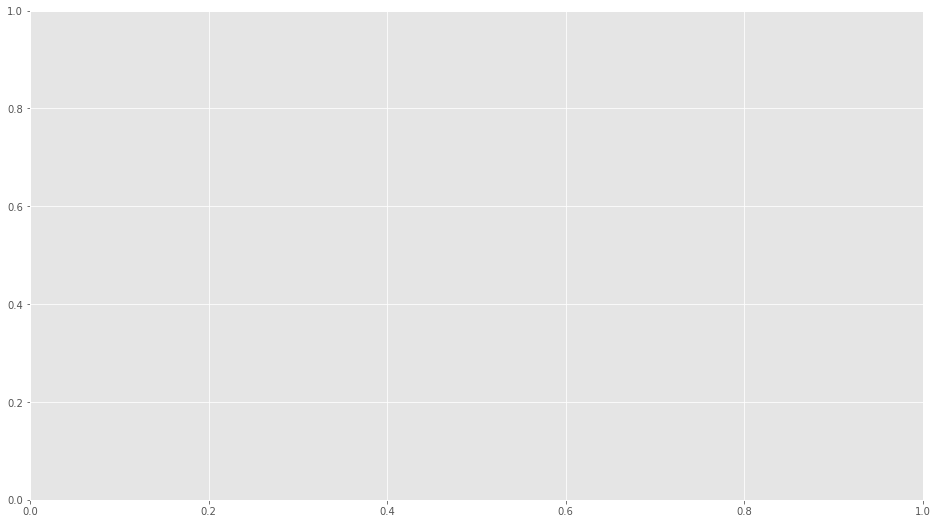

In [0]:
plt.plot ("Btl_Cnt","T_degC")

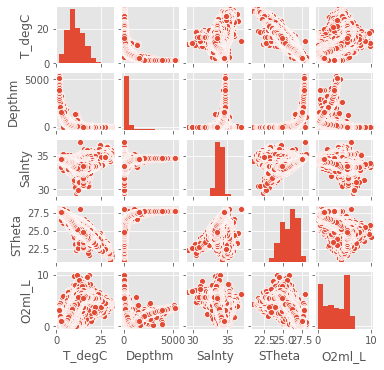

In [0]:
sb.pairplot(data,height=1,vars=["T_degC","Depthm","Salnty","STheta","O2ml_L"],kind='scatter')

In [0]:
model = sm.OLS(data.T_degC,pd.concat([data.Depthm,data.Salnty,data.STheta,data.O2ml_L], axis=1))
results=model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 T_degC   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.157e+08
Date:                Fri, 22 May 2020   Prob (F-statistic):                        0.00
Time:                        19:34:58   Log-Likelihood:                     -2.1518e+05
No. Observations:              482248   AIC:                                  4.304e+05
Df Residuals:                  482244   BIC:                                  4.304e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [0]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(dataframe)

ValueError: ignored